#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Цель проекта: построить модель для такого предсказания.

Ключевой показатель успеха: значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Для достижения цели необходимо выполнить следующие задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные с учётом сезонности и создать новые переменные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке, сравнить результат с требуемым щначением и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Планируется выполнять задачи в том порядке, в каком они указаны в содержании ниже.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Установка-и-подключение-библиотек" data-toc-modified-id="Установка-и-подключение-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Установка и подключение библиотек</a></span></li><li><span><a href="#Загрузка-и-ресэмплинг-датасета" data-toc-modified-id="Загрузка-и-ресэмплинг-датасета-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и ресэмплинг датасета</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Исследование-сезонности" data-toc-modified-id="Исследование-сезонности-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Исследование сезонности</a></span></li><li><span><a href="#Создание-и-проверка-состоятельности-переменных" data-toc-modified-id="Создание-и-проверка-состоятельности-переменных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание и проверка состоятельности переменных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Настройка-гиперпараметров" data-toc-modified-id="Настройка-гиперпараметров-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Настройка гиперпараметров</a></span></li><li><span><a href="#Поиск-по-решётке" data-toc-modified-id="Поиск-по-решётке-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Поиск по решётке</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка

### Установка и подключение библиотек

In [1]:
!pip install -Uq scipy
!pip install -Uq scikit-learn
!pip install -Uq matplotlib
!pip install -Uq catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn import set_config

from catboost import CatBoostRegressor

RANDOM_STATE = 42
set_config(transform_output="pandas")

### Загрузка и ресэмплинг датасета

In [3]:
def check_and_read(path, index_col=None, parse_dates=None):
    if os.path.exists(path):
        return pd.read_csv(path, index_col=index_col, parse_dates=parse_dates)
    else:
        print(f'Не найден файл по указанному пути: {path}')

        
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
target = 'num_orders'
df.sort_index(inplace=True)
print(df.index.is_monotonic_increasing)
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df = df.resample('1H').sum()
df

C:\Users\hydro\AppData\Local\Temp\ipykernel_16156\1978968788.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Дата установлена в качестве индекса, ресэмплинг с периодичности 10 минут до 1 часа произведён успешно. Проверено, что встречающиеся даты монотонно возрастают. В наборе данных представлены сведения с 1 марта по 31 августа 2018 года. Помимо индекса присутствует только один столбец - зависимая переменная.

## Анализ

### Исследование сезонности

Исследуем сезонность. Как видно, тренд - в целом возрастающее количество заказов, сезонность наблюдается с периодичностью, похожей на неделю (сезонность по дням недели), а скачки активности в остатках часто расположены рядом с праздниками (8 марта, майские праздники, 12 июня). В свою очередь, на уровне недели наблюдается сезонность внутри каждого дня по периодам, близким к часу-двум:

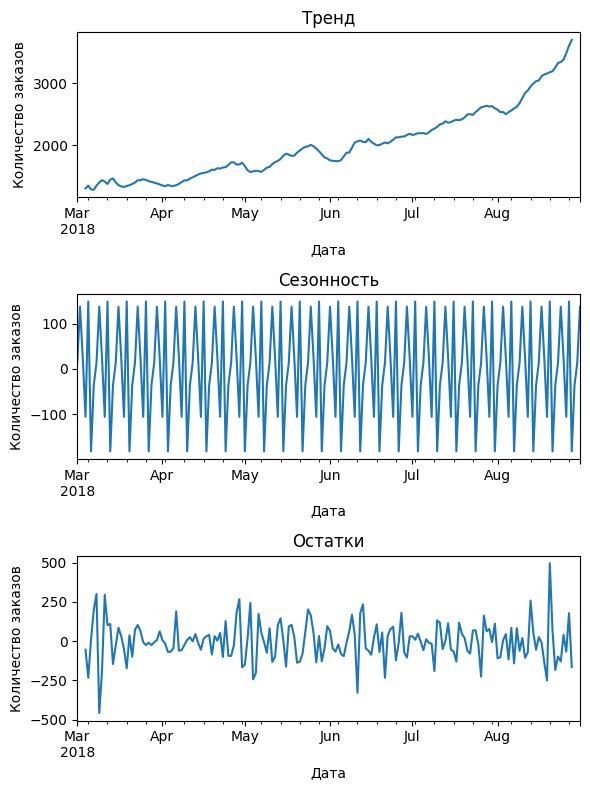

In [5]:
decomposed = seasonal_decompose(df[target].resample('1D').sum())
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

Дополнительно проверим, как меняется количество суммарное количество заказов за день, неделю и месяц:

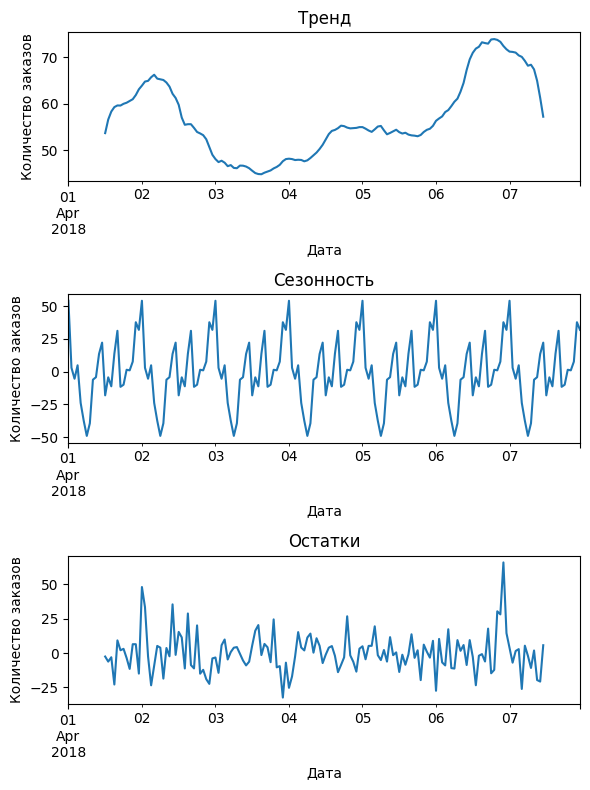

In [6]:
decomposed1 = seasonal_decompose(df.loc['2018-04-01':'2018-04-07', target])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed1.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed1.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed1.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

### Создание и проверка состоятельности переменных

На основе приведённых графиков создадим новые календарные признаки, отражающие основные элементы сезонности и тренда, без потери информации о дате и времени. Такими переменными станут номер часа внутри суток, лень недели и номер недели. Дополнительно добавим переменные с отстающими значениями и скользящим средним:

In [7]:
df['hour'] = df.index.hour
df['weekofyear'] = df.index.isocalendar().week
df['dayofweek'] = df.index.dayofweek

max_lag = 7
rolling_mean_size = 7

for lag in range(1, max_lag + 1):
    df['lag_{}'.format(lag)] = df[target].shift(lag)

df['rolling_mean'] = df[target].shift().rolling(rolling_mean_size).mean()

#df['out'] = 0
#df[(df.index.day==8) & (df.index.month==3) | (df.index.day==1) & (df.index.month==5) | (df.index.day==9) & (df.index.month==5) | (df.index.day==12) & (df.index.month==6)] = 1

df = df.dropna()

Ещё раз убедимся в правильности выделенных переменных и посмотрим на то, как меняется среднее значение в каждый час дня, день недели и каждую неделю (серым выделены значения стандартных отклонений). Как видно, пик активности приходится на ночь, когда городской транспорт не работает, а основной спад - на раннее утро с 5 до 7-8.

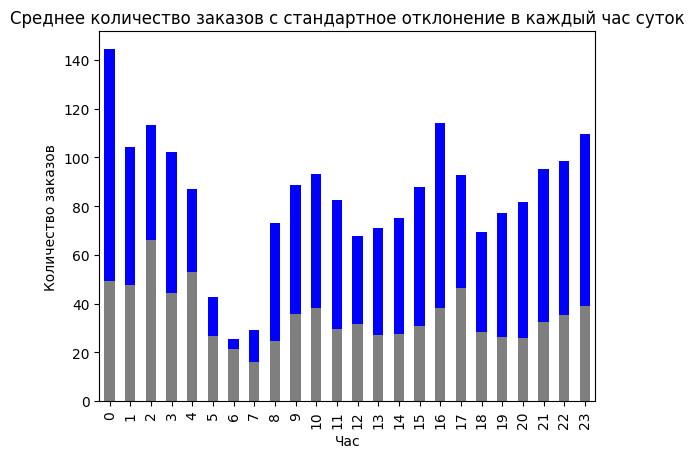

In [8]:
df.groupby('hour')['num_orders'].mean().plot(kind='bar', color='blue')
df.groupby('hour')['num_orders'].std().plot(kind='bar', color='yellow', alpha=0.5)
plt.title('Среднее количество заказов с стандартное отклонение в каждый час суток')
plt.xlabel('Час')
plt.ylabel('Количество заказов')
plt.show()

По дням недели разница в среднем не велика, небольшие пики приходятся на понедельник и пятницу, а спад на вторник.

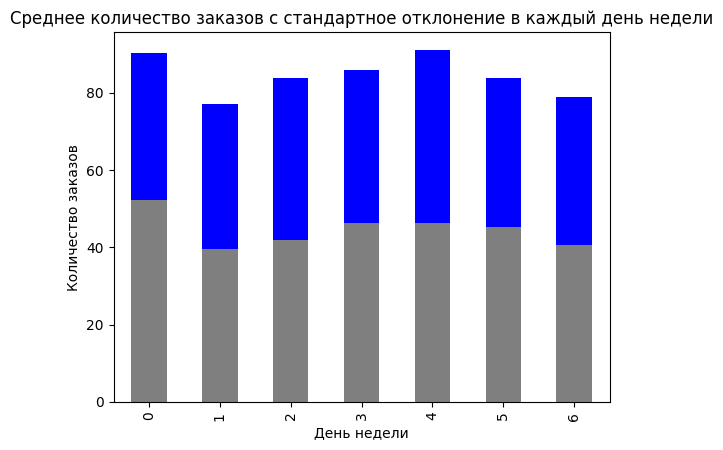

In [9]:
df.groupby('dayofweek')['num_orders'].mean().plot(kind='bar', color='blue')
df.groupby('dayofweek')['num_orders'].std().plot(kind='bar', color='yellow', alpha=0.5)
plt.title('Среднее количество заказов с стандартное отклонение в каждый день недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.show()

По номерам недели виден отчётливый восходящий тренд.

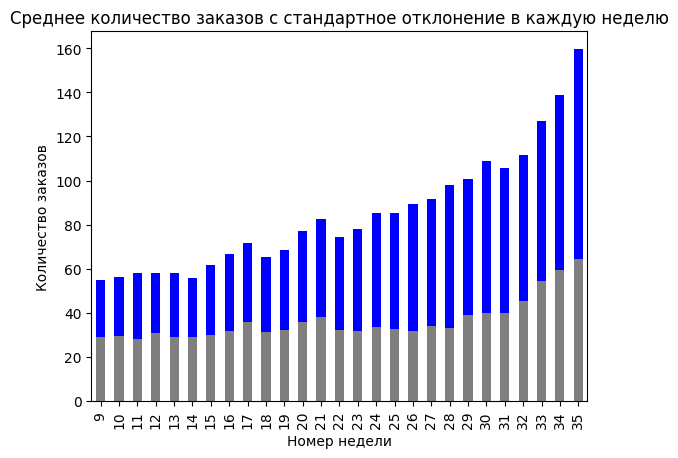

In [10]:
df.groupby('weekofyear')['num_orders'].mean().plot(kind='bar', color='blue')
df.groupby('weekofyear')['num_orders'].std().plot(kind='bar', color='yellow', alpha=0.5)
plt.title('Среднее количество заказов с стандартное отклонение в каждую неделю')
plt.xlabel('Номер недели')
plt.ylabel('Количество заказов')
plt.show()

По итогам анализа видно, что час и день недели нелинейно и немонотонно связаны с количеством заказов, а значит, эти переменные лучше считать категориальными.

Проверим стационарность ряда. p-значение 0,028 менее уровня значимости 0,05; ряд можно считать стационарным.

In [11]:
result = adfuller(df['num_orders'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -3.0806369578196593
p-value: 0.02801972266684902
Critical Values: {'1%': -3.4318445496379937, '5%': -2.8622004086791435, '10%': -2.567121539885148}


## Обучение

### Настройка гиперпараметров

Разделим выборку на обучающую и тестовую в соотношении 9 к 1 и проведём поиск по решётке. Испробуем линейную регрессию с квадратичной регуляризацией, алгоритм ближайших соседей и метод опорных векторов с двумя ядрами: линейным и радиальным.

In [12]:
df.loc[:, 'dayofweek'] = df['dayofweek'].astype('category')
df.loc[:, 'hour'] = df['hour'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], shuffle = False, test_size=0.1)

ohe_columns = df[['dayofweek', 'hour']].columns
num_columns = df.drop([target, 'dayofweek', 'hour'], axis=1).columns

num_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns),
],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('selector', SelectKBest(k='all')),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4409 entries, 2018-03-01 07:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4409 non-null   int64  
 1   hour          4409 non-null   int32  
 2   weekofyear    4409 non-null   UInt32 
 3   dayofweek     4409 non-null   int32  
 4   lag_1         4409 non-null   float64
 5   lag_2         4409 non-null   float64
 6   lag_3         4409 non-null   float64
 7   lag_4         4409 non-null   float64
 8   lag_5         4409 non-null   float64
 9   lag_6         4409 non-null   float64
 10  lag_7         4409 non-null   float64
 11  rolling_mean  4409 non-null   float64
dtypes: UInt32(1), float64(8), int32(2), int64(1)
memory usage: 400.4 KB


In [14]:
param_grid = [
    {
        'models': [Ridge(random_state=RANDOM_STATE, max_iter=5000)],
        'models__alpha': [0.01, 0.1, 0.5, 1, 5],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    },

    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(1, 11),
        'models__metric': ['manhattan', 'euclidean'],
        'models__algorithm': ['auto', 'brute'],
        'models__weights': ['uniform', 'distance'],
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
    },
    {
        'models': [SVR()],
        'models__C': [10, 40, 60, 80],
        'models__gamma': [0.05, 0.1, 0.5],
        'models__kernel': ['rbf'],
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [RobustScaler()],
    },
    {
        'models': [SVR()],
        'models__C': [10, 20, 40],
        'models__kernel': ['linear'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
    },
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=False, cat_features=['ohe__dayofweek', 'ohe__hour'])],
        'models__depth': [4, 5],
        'models__iterations': [240, 360],
        'models__learning_rate': [0.1, 0.2],
        'preprocessor__ohe': ['passthrough'],
        'preprocessor__num__poly': ['passthrough'],
    },
]

### Поиск по решётке

In [15]:
hyper_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=TimeSeriesSplit(n_splits = 5),
    scoring='neg_root_mean_squared_error',
    verbose=3,
    n_jobs=-1,
    return_train_score=True,
)

use_prev = True
filename = 'temp_model.sav'
if use_prev:
    hyper_search = pickle.load(open(filename, 'rb'))
else:
    hyper_search.fit(X_train, y_train)
    pickle.dump(hyper_search, open(filename, 'wb'))

print('Лучшая модель и её параметры:\n\n', hyper_search.best_estimator_)
print(hyper_search.best_params_)
print(f'Метрика RMSE лучшей модели на тренировочной выборке: {-hyper_search.best_score_:.3f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', 'passthrough',
                                                  Index(['dayofweek', 'hour'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   'passthrough')]),
                                                  Index(['weekofyear', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'rolling_mean'],
      dtype='object'))])),
                ('selector', SelectKBest(k='all')),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x00

Как видно, наилучший полученный результат при кросс-валидации: 24,579; лучшая модель - градиентный бустинг с глубиной 5, количеством деревьев 240, скоростью обучения 0.1; стандартизация - MinMaxScaler. При этом линейные модели показывают себя почти так же хорошо, а нелинейные модели (кроме бустинга) демонстрируют заметно худшее качество, что скорее всего говорит о квазилинейном характере связи.

## Тестирование

In [16]:
pred_test = hyper_search.predict(X_test)
print(f'RMSE на тестовой выборке: {rmse(pred_test, y_test):.2f}')

RMSE на тестовой выборке: 40.17


Как видно, линейная модель показывает качество RMSE=40,17 на тестовой выборке, что меньше ключевого порога в 48.

## Вывод

В ходе проекта были получены следующие результаты:  
1. Данные загружены и ресэмплированы к одному часу, пропусков нет. Датасет охватывает период с 1 марта по 31 августа 2018 года.
2. 
 * В данных обнаружена сезонность по дням недели и часам в дне. Наибольший спад количества заказов с 5 до 7 утра, пик - ночью. Разница по дням недели невелика. Установлено, что ряд стационарен на уровне значимости 0.05, среднее количество заказов в час почти монотонно возрастает с каждой неделей с менее 60 до почти 160. 
 * Созданы переменные с указанием часа, дня недели и номера недели. Также добавлены отстающие значения и скользящее среднее за 7 дней.
3. Найдена наилучшая модель: градиентный бустинг с параметрами глубина дерева: 5; количество деревьев: 240; скорость обучения: 0,1; стандартизация: MinMax. RMSE при кросс-валидации: 24,579. 
4. RMSE на тестовом наборе данных: 40,17. Показатель на тесте менее 48, требуемый результат достигнут.